# 🛫 가중치 초기화

### 📥 Import

In [45]:
import os
import sys
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Thanks to **dhaitz**!
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# 한글폰트 설정
import matplotlib as mpl
mpl.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
print(f'현재 작업 디렉토리: "{os.getcwd()}"')

from common.gradient import numerical_gradient
from common.layers import *
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD
from common.util import smooth_curve
from dataset.mnist import load_mnist

현재 작업 디렉토리: "g:\zer0ken\ms-ai-school\neural-net\ch05 학습 기술"


### 📐 초기 표준편차와 활성함수에 따른 가중치 분포

#### 💡 활성 함수

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x) 

#### 🖼️ 시각화

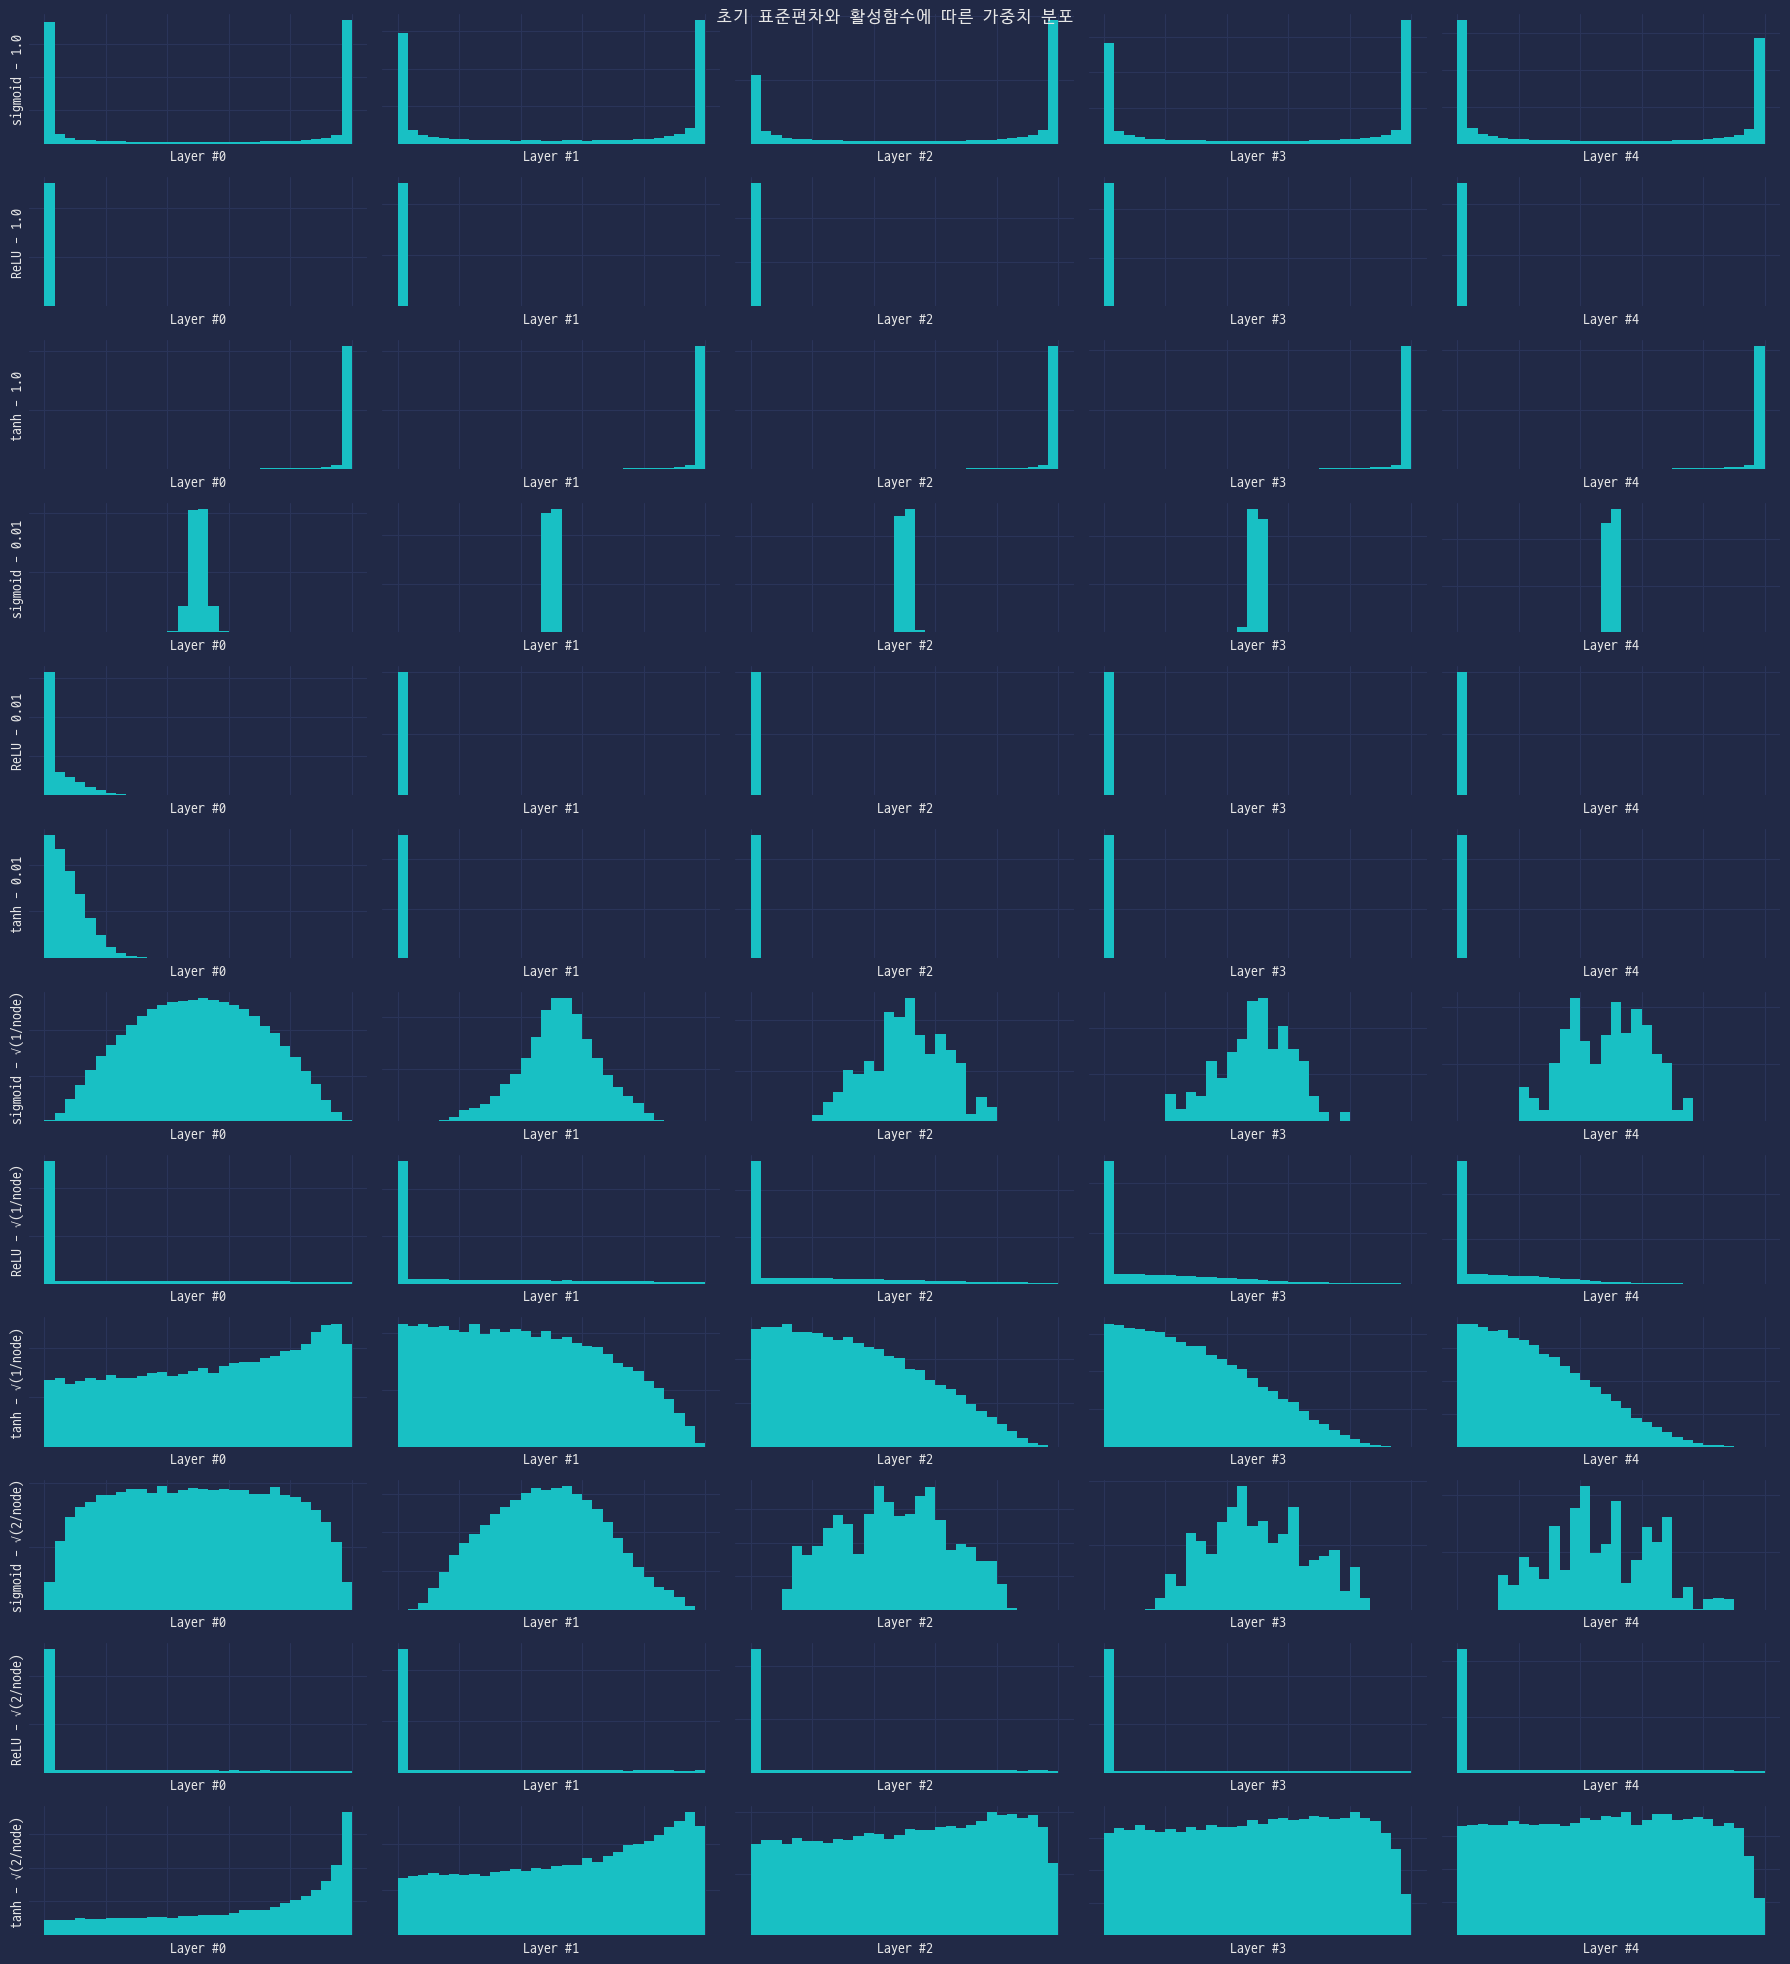

In [44]:
input_data = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
stds = {'1.0': 1.0, '0.01': 0.01, '√(1/node)': np.sqrt(1.0 / node_num), '√(2/node)': np.sqrt(2.0 / node_num)}
activators = {'sigmoid': sigmoid, 'ReLU': relu, 'tanh': tanh}

def get_activations(std=1.0, activator=sigmoid):
    x = input_data.copy()
    activations = []
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i - 1]
        w = np.random.randn(node_num, node_num) * std
        a = np.dot(x, w)
        z = activator(a)
        activations.append(z)
    return activations

subplot_row = len(activators) * len(stds)
subplot_col = hidden_layer_size

plt.figure(figsize=(18, 20))

for i, (std_label, std) in enumerate(stds.items()):
    for j, (activator_name, activator) in enumerate(activators.items()):
        offset = (i * len(activators) + j) * subplot_col
        activations = get_activations(std, activator)
        for k, a in enumerate(activations):
            plt.subplot(
                subplot_row, 
                subplot_col, 
                offset + k + 1
            )
            plt.tick_params(labelleft=False, labelbottom=False)
            plt.xlabel(f'Layer #{k}')
            if k == 0:
                plt.ylabel(f'{activator_name} - {std_label}')
            plt.hist(a.flatten(), 30, range=(0, 1))

plt.suptitle('초기 표준편차와 활성함수에 따른 가중치 분포')
plt.tight_layout()
plt.show()

### ⚗️ 초기화 전략에 따른 학습 속도

In [46]:
"""
0. MNIST 데이터셋 불러오기
"""
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iter = 10000

"""
1. 실험용 설정
"""
weight_init_strategies = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for strategy, weight_type in weight_init_strategies.items():
    networks[strategy] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10, weight_init_std=weight_type
    )
    train_loss[strategy] = []

"""
2. 훈련
"""
for i in range(max_iter + 1):
    if i < max_iter:
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        for strategy in weight_init_strategies:
            grads = networks[strategy].gradient(x_batch, t_batch)
            optimizer.update(networks[strategy].params, grads)
            loss = networks[strategy].loss(x_batch, t_batch)
            train_loss[strategy].append(loss)

    if i % 1000 == 0:
        clear_output()
        print(f'#{i} Iteration')
        
        for strategy in weight_init_strategies:
            loss = networks[strategy].loss(x_batch, t_batch)
            print(f'{strategy:8}: {loss=:.6f}')

#10000 Iteration
std=0.01: loss=2.304042
Xavier  : loss=0.081612
He      : loss=0.077994


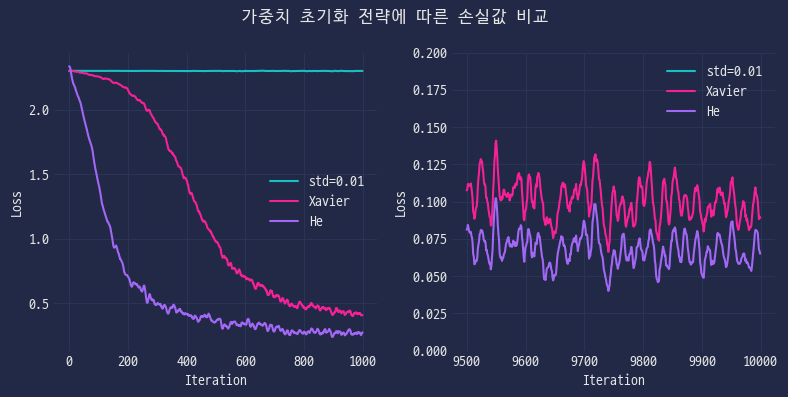

In [53]:
"""
3. 그래프
"""
x = np.arange(max_iter)
y = {strategy: smooth_curve(train_loss[strategy]) for strategy in weight_init_strategies}

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
for strategy in weight_init_strategies:
    plt.plot(x[:1000], y[strategy][:1000],label=strategy)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for strategy in weight_init_strategies:
    plt.plot(x[-500:], y[strategy][-500:],label=strategy)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim(0, 0.2)
plt.legend()

plt.suptitle('가중치 초기화 전략에 따른 손실값 비교')
plt.tight_layout()
plt.show()